In [24]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset
from HySpecLab.metrics import rmse, sad

# LMM and ELMM solution

In [25]:
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData/data')
dataset = SyntheticDataset(config.Synthetic_PATH)

In [26]:
from scipy import io as sio

endmember_estimation = sio.loadmat(os.path.join(result_path, 'endmember_estimation.mat'))
vca_ee = torch.tensor(endmember_estimation['VCA'])
nfindr_ee = torch.tensor(endmember_estimation['NFINDR'])

sad_result = sad(vca_ee, dataset.endmembers())
vca_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

sad_result = sad(nfindr_ee, dataset.endmembers())
nfindr_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

vca_ee = vca_ee[vca_idx]
nfindr_ee = nfindr_ee[nfindr_idx]

In [27]:
X_true = dataset.A @ dataset.E

In [28]:
input = sio.loadmat(os.path.join(result_path, 'input.mat'))
X = torch.tensor(input['X'].reshape(-1, input['X'].shape[-1], order='F'))

## Endmembers

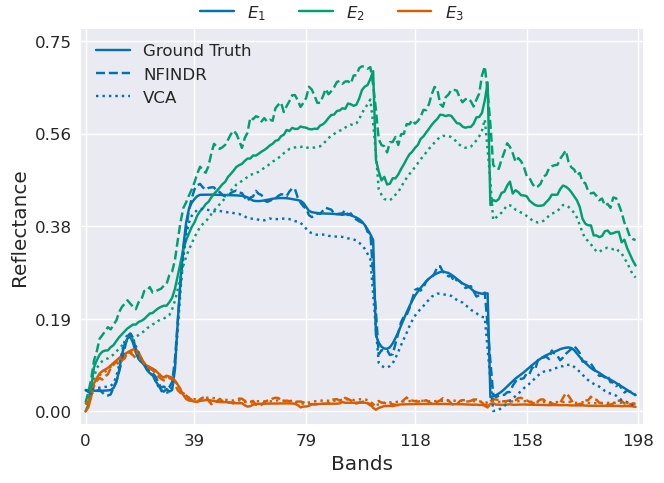

In [29]:
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, .75), 
                      endmember_estimation=[nfindr_ee, vca_ee],
                      ee_labels=['Ground Truth', 'NFINDR', 'VCA'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/endmembers_estimation.pdf'), bbox_inches='tight')

In [30]:
from HySpecLab.metrics import sad

sad_result_vca = sad(vca_ee, dataset.endmembers())
print(sad_result_vca, np.diagonal(sad_result_vca.numpy()).mean())

sad_result_nfindr = sad(nfindr_ee, dataset.endmembers())
print(sad_result_nfindr, np.diagonal(sad_result_nfindr.numpy()).mean())

tensor([[0.0750, 0.5060, 1.1170],
        [0.4428, 0.0266, 1.0992],
        [1.0229, 0.9570, 0.1417]]) 0.08110774
tensor([[0.0447, 0.4578, 1.1320],
        [0.4485, 0.0495, 1.0695],
        [1.0316, 0.9516, 0.1950]]) 0.09640387


# Abundance

## LMM

In [13]:
FCLS = sio.loadmat(os.path.join(result_path, 'FCLS.mat'))
save_dir = os.path.join(result_path, 'imgs/LMM')

Xhat = FCLS['Xhat_NFINDR'].T

nfindr_reconstruct = torch.tensor(FCLS['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(FCLS['Xhat_VCA'].T)

# dataframe which contains the RMSE
# Saving metrics
import pandas as pd
lmm_df = pd.DataFrame(columns=['RMSE', 'Method', 'Endmember Estimation'])
lmm_df['RMSE'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
lmm_df['Method'] = ['LMM', 'LMM']
lmm_df['Endmember Estimation'] = ['NFINDR', 'VCA']
lmm_df

,RMSE,Method,Endmember Estimation
0,0.018642023,LMM,NFINDR
1,0.015409266,LMM,VCA


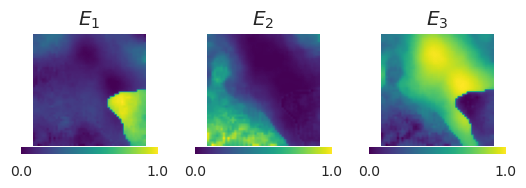

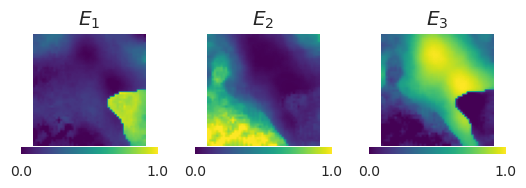

In [14]:
A = FCLS['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, nfindr_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = FCLS['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, vca_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')

## ELMM

In [17]:
ELMM = sio.loadmat(os.path.join(result_path, 'ELMM.mat'))
save_dir = os.path.join(result_path, 'imgs/ELMM')

from HySpecLab.metrics import rmse
nfindr_reconstruct = torch.tensor(ELMM['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(ELMM['Xhat_VCA'].T)

import pandas as pd
elmm_df = pd.DataFrame(columns=['RMSE', 'Method', 'Endmember Estimation'])
elmm_df['RMSE'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
elmm_df['Method'] = ['ELMM', 'ELMM']
elmm_df['Endmember Estimation'] = ['NFINDR', 'VCA']
elmm_df

,RMSE,Method,Endmember Estimation
0,0.017016926358207344,ELMM,NFINDR
1,0.016101922897469978,ELMM,VCA


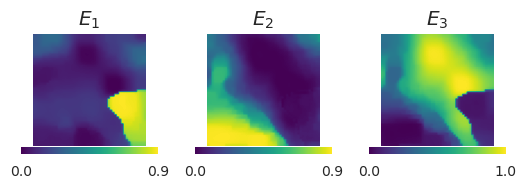

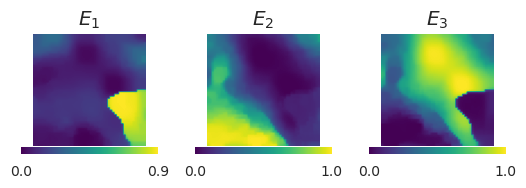

In [16]:
from utils import show_abundance
A = ELMM['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(np.abs(A[:, :, nfindr_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = ELMM['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(np.abs(A[:, :, vca_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')